In [1]:
import numpy as np
import pandas as pd
from utils import  amplitude_scaling, load_dataset, save_distance_matrix
from sklearn.neighbors import KNeighborsClassifier
from dtaidistance import dtw
from sklearn.metrics import classification_report 
from sklearn.model_selection import GridSearchCV, cross_val_predict
from utils import dtw_dist, top_flop_f1, decode_y
from pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    make_scorer
)
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_precision_recall
from sklearn.preprocessing import MinMaxScaler

# Global Distances Features: PCA applied to the distance matrix

## PAA-128

In [2]:
X_train_paa, y_train_paa, X_test_paa, y_test_paa, enc_dict = load_dataset('../dataset_ts/ts_data_paa128.npz')

### PCA

In [3]:
from sklearn.decomposition import PCA

In [4]:
euc_mat_paa, dtw_mat_paa = (np.load('distances/paa_matrices_unscaled.npz')['euclidean'], np.load('distances/paa_matrices_unscaled.npz')['dtw'])

In [5]:
train_dtw_mat_paa = dtw_mat_paa[:7500,:7500]
test_dtw_mat_paa = dtw_mat_paa[7500:,:7500]

train_euc_mat_paa = euc_mat_paa[:7500,:7500]
test_euc_mat_paa = euc_mat_paa[7500:,:7500]

EUCLIDEAN

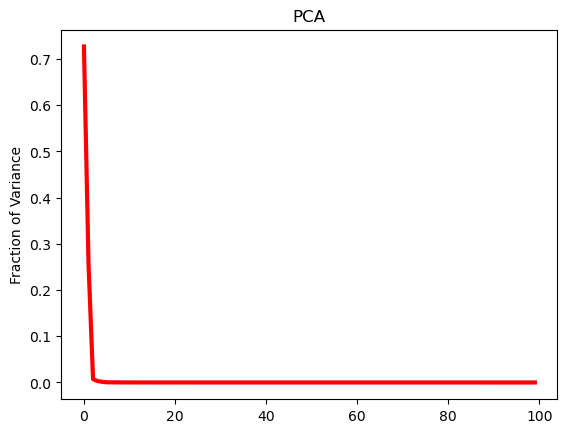

In [6]:
plt.plot(PCA(n_components=100).fit(train_euc_mat_paa).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

[]

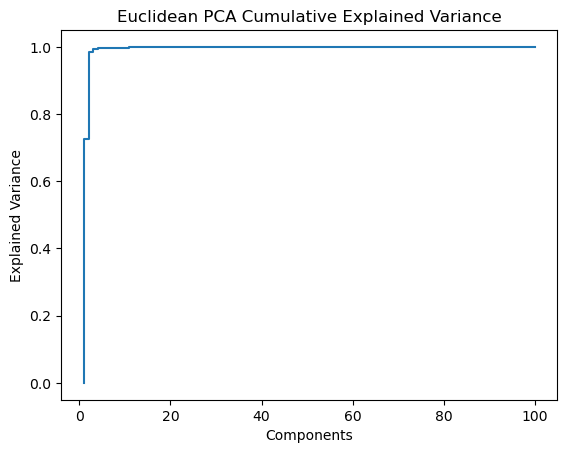

In [7]:
variance_ratio = PCA(n_components=100).fit(train_euc_mat_paa).explained_variance_ratio_
cumulative = [np.sum(variance_ratio[:i]) for i in range(variance_ratio.shape[0])]
plt.step(np.arange(1,101),cumulative)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title('Euclidean PCA Cumulative Explained Variance')
plt.plot()

10 components might be a reasonable choice

In [8]:
pca = PCA(n_components=10)
pca.fit(train_euc_mat_paa)

scaler = MinMaxScaler()


train_euc_pca_paa = scaler.fit_transform(pca.transform(train_euc_mat_paa))
test_euc_pca_paa = scaler.transform(pca.transform(test_euc_mat_paa))

model selection:

In [12]:
# KNN
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'manhattan'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(train_euc_pca_paa, y_train_paa)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=150,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 150, 'weights': 'distance'}
0.2613333333333333


                   precision    recall  f1-score   support

              emo       0.19      0.09      0.12       375
             folk       0.21      0.05      0.08       375
             goth       0.12      0.04      0.06       375
            happy       0.36      0.47      0.41       375
      heavy-metal       0.26      0.46      0.33       375
       honky-tonk       0.19      0.50      0.28       375
           j-idol       0.26      0.36      0.30       375
             kids       0.26      0.30      0.28       375
   minimal-techno       0.29      0.07      0.11       375
              mpb       0.10      0.05      0.06       375
          new-age       0.40      0.55      0.46       375
            opera       0.16      0.05      0.08       375
            piano       0.59      0.46      0.51       375
progressive-house       0.35      0.24      0.28       375
            salsa       0.17      0.27      0.21       375
        sertanejo       0.18      0.51      0.27       

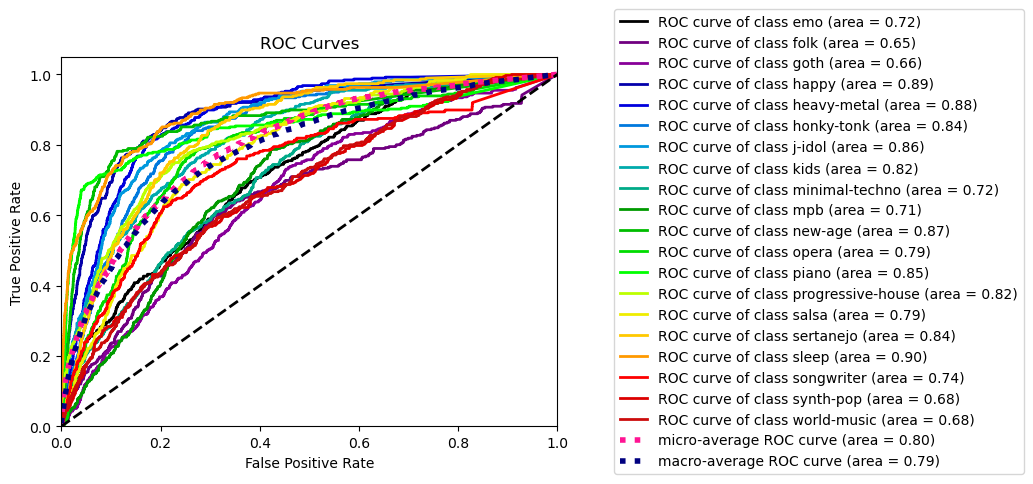

TOP 5 F1-SCORE:
piano: 0.512743628185907
sleep: 0.4857142857142857
new-age: 0.45964125560538116
happy: 0.409778812572759
heavy-metal: 0.33204633204633205


FLOP 5 F1-SCORE:
goth: 0.06060606060606061
mpb: 0.061930783242258654
opera: 0.07661290322580645
folk: 0.0815450643776824
world-music: 0.08928571428571429


In [13]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=150, weights='distance')
y_pred = decode_y(cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

In [14]:
# DECISION TREE
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(train_euc_pca_paa, y_train_paa)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 100}
0.23479999999999998


                   precision    recall  f1-score   support

              emo       0.15      0.08      0.10       375
             folk       0.08      0.02      0.04       375
             goth       0.14      0.06      0.09       375
            happy       0.33      0.37      0.35       375
      heavy-metal       0.27      0.34      0.30       375
       honky-tonk       0.19      0.34      0.25       375
           j-idol       0.25      0.25      0.25       375
             kids       0.22      0.33      0.26       375
   minimal-techno       0.14      0.05      0.07       375
              mpb       0.11      0.04      0.06       375
          new-age       0.41      0.59      0.48       375
            opera       0.22      0.17      0.19       375
            piano       0.59      0.37      0.45       375
progressive-house       0.23      0.23      0.23       375
            salsa       0.16      0.35      0.22       375
        sertanejo       0.15      0.43      0.23       

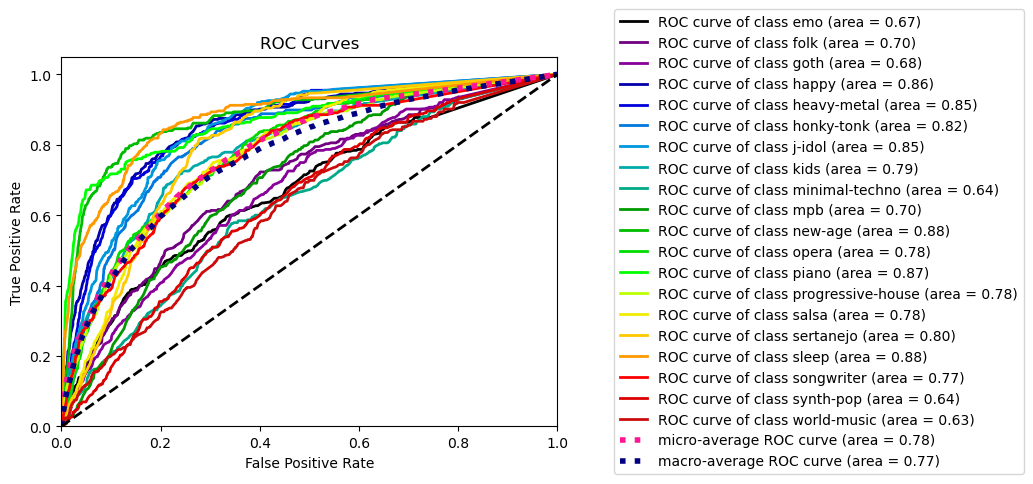

TOP 5 F1-SCORE:
new-age: 0.48253275109170307
piano: 0.45320197044334976
sleep: 0.4490934449093445
happy: 0.3505674653215637
heavy-metal: 0.30105017502917153


FLOP 5 F1-SCORE:
synth-pop: 0.03146067415730337
folk: 0.037037037037037035
world-music: 0.04932735426008968
mpb: 0.06072106261859583
minimal-techno: 0.07480314960629922


In [9]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
y_pred = decode_y(cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

In [15]:
clf = GaussianNB()
clf.fit(train_euc_pca_paa[:6000], y_train_paa[:6000])
print(clf.score(train_euc_pca_paa[6000:], y_train_paa[6000:]))

0.246


                   precision    recall  f1-score   support

              emo       0.15      0.05      0.08       375
             folk       0.00      0.00      0.00       375
             goth       0.05      0.01      0.01       375
            happy       0.37      0.43      0.40       375
      heavy-metal       0.20      0.59      0.30       375
       honky-tonk       0.20      0.59      0.29       375
           j-idol       0.20      0.32      0.25       375
             kids       0.35      0.21      0.26       375
   minimal-techno       0.25      0.13      0.17       375
              mpb       0.10      0.02      0.04       375
          new-age       0.38      0.45      0.41       375
            opera       0.26      0.06      0.10       375
            piano       0.51      0.59      0.55       375
progressive-house       0.27      0.27      0.27       375
            salsa       0.14      0.05      0.07       375
        sertanejo       0.16      0.64      0.26       

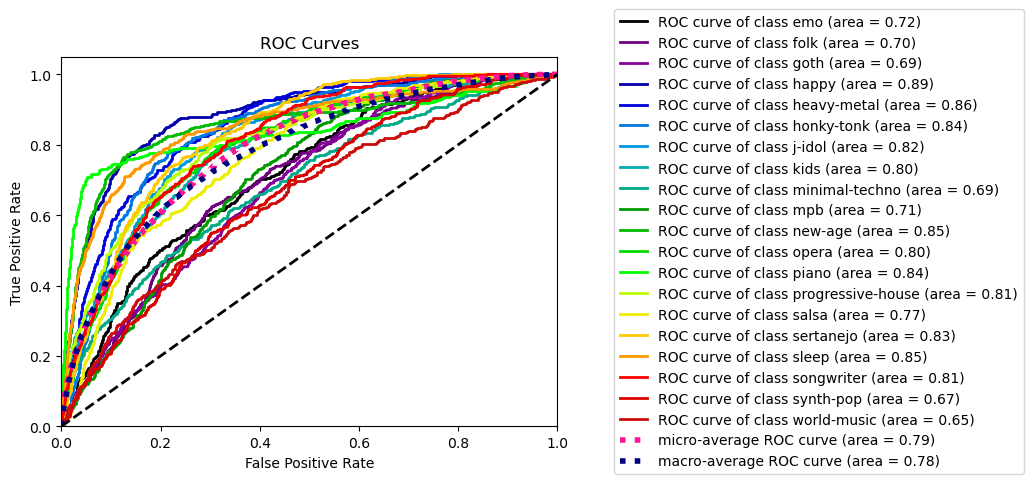

TOP 5 F1-SCORE:
piano: 0.5492610837438424
new-age: 0.4147239263803681
happy: 0.39657282741738065
heavy-metal: 0.2981867024848892
honky-tonk: 0.29388297872340424


FLOP 5 F1-SCORE:
folk: 0.0
synth-pop: 0.0
world-music: 0.00516795865633075
goth: 0.009569377990430622
mpb: 0.03862660944206009


In [10]:
# naive bayes selected model
model = GaussianNB()
y_pred = decode_y(cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_euc_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

test:

In [16]:
# knn
clf = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=150,
                     weights='distance')
clf.fit(train_euc_pca_paa, y_train_paa)
y_pred = clf.predict(test_euc_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.31      0.11      0.16       125
             folk       0.14      0.03      0.05       125
             goth       0.06      0.02      0.03       125
            happy       0.35      0.46      0.40       125
      heavy-metal       0.29      0.44      0.35       125
       honky-tonk       0.20      0.50      0.28       125
           j-idol       0.26      0.35      0.30       125
             kids       0.27      0.31      0.29       125
   minimal-techno       0.32      0.10      0.16       125
              mpb       0.19      0.09      0.12       125
          new-age       0.39      0.55      0.46       125
            opera       0.22      0.08      0.12       125
            piano       0.56      0.46      0.50       125
progressive-house       0.36      0.29      0.32       125
            salsa       0.18      0.27      0.22       125
        sertanejo       0.17      0.49      0.25       

In [17]:
# decision tree
clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_split=100,
                       random_state=8)
clf.fit(train_euc_pca_paa, y_train_paa)
y_pred = clf.predict(test_euc_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.00      0.00      0.00       125
             folk       0.06      0.01      0.01       125
             goth       0.05      0.02      0.02       125
            happy       0.26      0.30      0.28       125
      heavy-metal       0.24      0.42      0.30       125
       honky-tonk       0.20      0.43      0.28       125
           j-idol       0.23      0.17      0.20       125
             kids       0.19      0.44      0.27       125
   minimal-techno       0.13      0.14      0.13       125
              mpb       0.06      0.01      0.01       125
          new-age       0.42      0.50      0.46       125
            opera       0.21      0.12      0.15       125
            piano       0.55      0.36      0.43       125
progressive-house       0.30      0.23      0.26       125
            salsa       0.14      0.28      0.19       125
        sertanejo       0.18      0.46      0.26       

c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [18]:
# naive bayes
clf = GaussianNB()
clf.fit(train_euc_pca_paa, y_train_paa)
y_pred = clf.predict(test_euc_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.16      0.06      0.08       125
             folk       0.00      0.00      0.00       125
             goth       0.18      0.02      0.03       125
            happy       0.35      0.44      0.39       125
      heavy-metal       0.20      0.57      0.29       125
       honky-tonk       0.20      0.61      0.30       125
           j-idol       0.20      0.33      0.25       125
             kids       0.35      0.19      0.25       125
   minimal-techno       0.15      0.08      0.10       125
              mpb       0.18      0.03      0.05       125
          new-age       0.36      0.43      0.40       125
            opera       0.25      0.05      0.08       125
            piano       0.48      0.57      0.52       125
progressive-house       0.31      0.30      0.31       125
            salsa       0.09      0.03      0.05       125
        sertanejo       0.17      0.70      0.27       

DTW

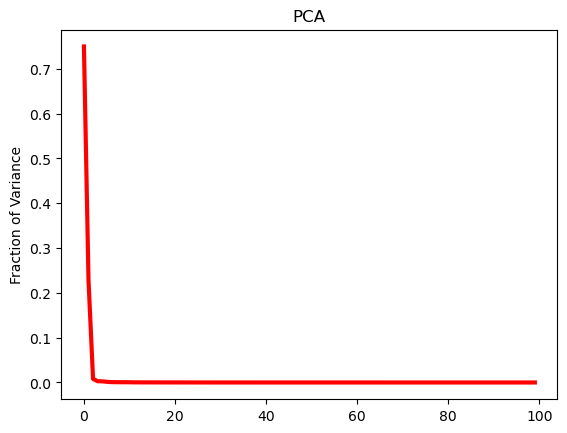

In [11]:
plt.plot(PCA(n_components=100).fit(train_dtw_mat_paa).explained_variance_ratio_, lw=3, color='r', ms=2)
plt.title("PCA")
plt.ylabel("Fraction of Variance")
plt.show()

[]

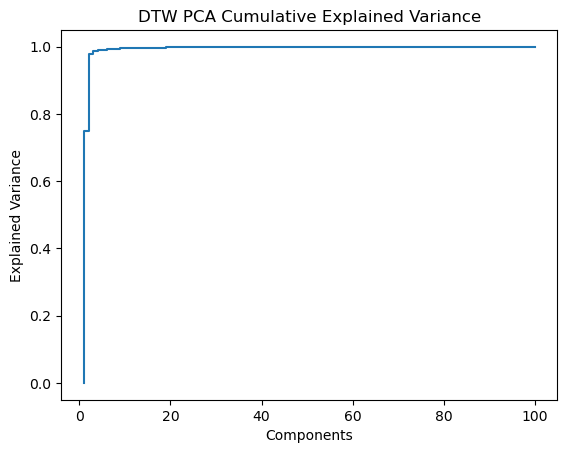

In [12]:
variance_ratio = PCA(n_components=100).fit(train_dtw_mat_paa).explained_variance_ratio_
cumulative = [np.sum(variance_ratio[:i]) for i in range(variance_ratio.shape[0])]
plt.step(np.arange(1,101),cumulative)
plt.xlabel('Components')
plt.ylabel('Explained Variance')
plt.title('DTW PCA Cumulative Explained Variance')
plt.plot()

10 components might be a reasonable choice

In [13]:
pca = PCA(n_components=10)
sclaer = MinMaxScaler()

pca.fit(train_dtw_mat_paa)
train_dtw_pca_paa = scaler.fit_transform(pca.transform(train_dtw_mat_paa))
test_dtw_pca_paa = scaler.transform(pca.transform(test_dtw_mat_paa))

Model selection:

In [22]:
# knn
parameters = {'n_neighbors': [1,5,10,15,20,30,40,50,60,80,100,125,150,200],
              'weights': ['distance', 'uniform'],
              'metric': ['euclidean', 'cosine', 'cityblock'],
              'n_jobs': [-1]
              }
knn = KNeighborsClassifier()
clf = GridSearchCV(
    knn, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    )
clf.fit(train_dtw_pca_paa, y_train_paa)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=150,
                     weights='distance')
{'metric': 'cosine', 'n_jobs': -1, 'n_neighbors': 150, 'weights': 'distance'}
0.2785333333333333


                   precision    recall  f1-score   support

              emo       0.17      0.07      0.10       375
             folk       0.16      0.05      0.08       375
             goth       0.09      0.02      0.03       375
            happy       0.40      0.46      0.42       375
      heavy-metal       0.30      0.46      0.36       375
       honky-tonk       0.22      0.46      0.30       375
           j-idol       0.26      0.32      0.29       375
             kids       0.26      0.35      0.30       375
   minimal-techno       0.34      0.10      0.15       375
              mpb       0.09      0.03      0.04       375
          new-age       0.40      0.49      0.44       375
            opera       0.20      0.14      0.17       375
            piano       0.58      0.48      0.53       375
progressive-house       0.32      0.26      0.29       375
            salsa       0.20      0.43      0.28       375
        sertanejo       0.23      0.58      0.33       

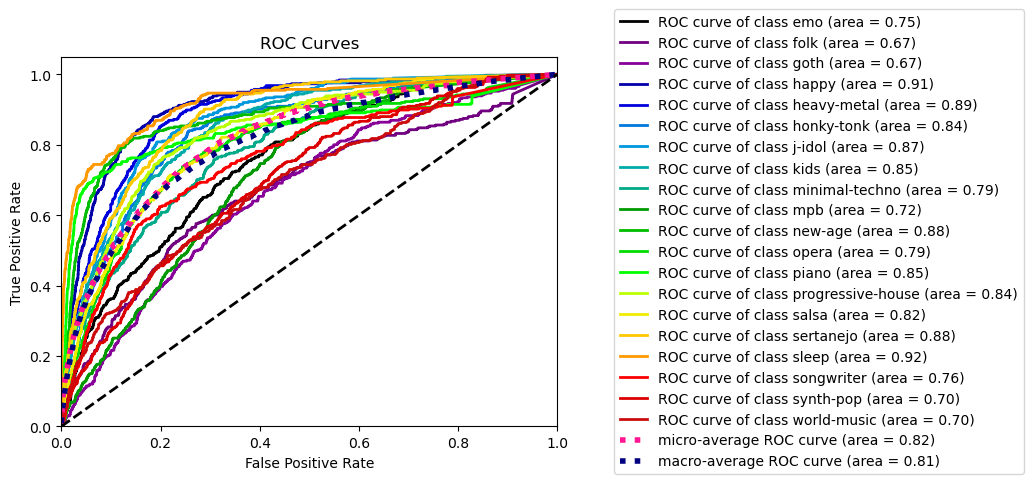

TOP 5 F1-SCORE:
sleep: 0.5723793677204659
piano: 0.5269286754002911
new-age: 0.4410011918951132
happy: 0.4246913580246914
heavy-metal: 0.3649789029535865


FLOP 5 F1-SCORE:
goth: 0.03070175438596491
mpb: 0.0437375745526839
folk: 0.08032128514056225
emo: 0.10093457943925234
synth-pop: 0.11353711790393013


In [15]:
# knn selected model
model = KNeighborsClassifier(metric='cosine', n_jobs=-1, n_neighbors=150, weights='distance')
y_pred = decode_y(cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

In [25]:
# decision tree
parameters = {'criterion': ['entropy'],
              'min_samples_split': [2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'min_samples_leaf': [1,2,4,6,8,10,14,18,24,30,40,50,60,75,100],
              'max_depth': [4,6,8,10,12,14,16,20,24]
              }
dtc = DecisionTreeClassifier(random_state=8)
clf = GridSearchCV(
    dtc, 
    parameters, 
    scoring='accuracy', 
    n_jobs=-1,
    refit=True,
    verbose=2
    )
clf.fit(train_dtw_pca_paa, y_train_paa)
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)

Fitting 5 folds for each of 1890 candidates, totalling 9450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=6,
                       min_samples_split=100, random_state=8)
{'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 6, 'min_samples_split': 100}
0.2504


                   precision    recall  f1-score   support

              emo       0.17      0.08      0.11       375
             folk       0.08      0.03      0.05       375
             goth       0.06      0.02      0.03       375
            happy       0.29      0.41      0.34       375
      heavy-metal       0.27      0.39      0.32       375
       honky-tonk       0.20      0.41      0.27       375
           j-idol       0.26      0.25      0.25       375
             kids       0.20      0.27      0.23       375
   minimal-techno       0.16      0.14      0.15       375
              mpb       0.10      0.04      0.06       375
          new-age       0.40      0.49      0.44       375
            opera       0.21      0.16      0.18       375
            piano       0.56      0.44      0.50       375
progressive-house       0.23      0.21      0.22       375
            salsa       0.18      0.29      0.22       375
        sertanejo       0.22      0.48      0.30       

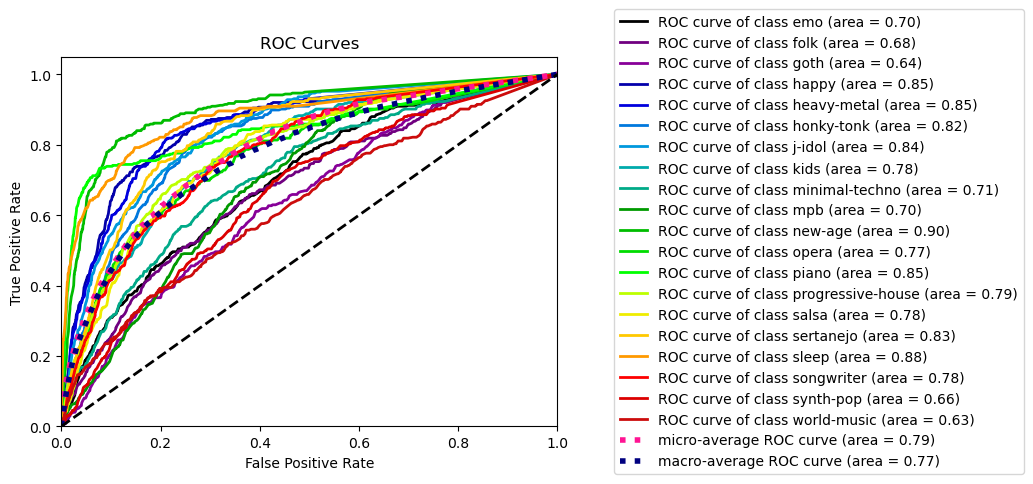

TOP 5 F1-SCORE:
sleep: 0.49865951742627346
piano: 0.4962630792227205
new-age: 0.43937575030012005
happy: 0.34146341463414637
heavy-metal: 0.31521739130434784


FLOP 5 F1-SCORE:
synth-pop: 0.004807692307692308
goth: 0.03125
folk: 0.045112781954887216
mpb: 0.05725190839694656
emo: 0.11131059245960502


In [16]:
# decision tree selected model
model = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=6,
                       min_samples_split=100, random_state=8)
y_pred = decode_y(cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

In [24]:
# naive bayes
clf = GaussianNB()
clf.fit(train_dtw_pca_paa[:6000], y_train_paa[:6000])
print(clf.score(train_dtw_pca_paa[6000:], y_train_paa[6000:]))

0.264


                   precision    recall  f1-score   support

              emo       0.17      0.03      0.05       375
             folk       0.00      0.00      0.00       375
             goth       0.11      0.03      0.05       375
            happy       0.39      0.44      0.42       375
      heavy-metal       0.25      0.63      0.35       375
       honky-tonk       0.20      0.41      0.27       375
           j-idol       0.25      0.31      0.27       375
             kids       0.28      0.23      0.25       375
   minimal-techno       0.21      0.04      0.07       375
              mpb       0.11      0.07      0.08       375
          new-age       0.47      0.39      0.42       375
            opera       0.23      0.25      0.24       375
            piano       0.50      0.58      0.53       375
progressive-house       0.28      0.21      0.24       375
            salsa       0.19      0.29      0.23       375
        sertanejo       0.18      0.69      0.29       

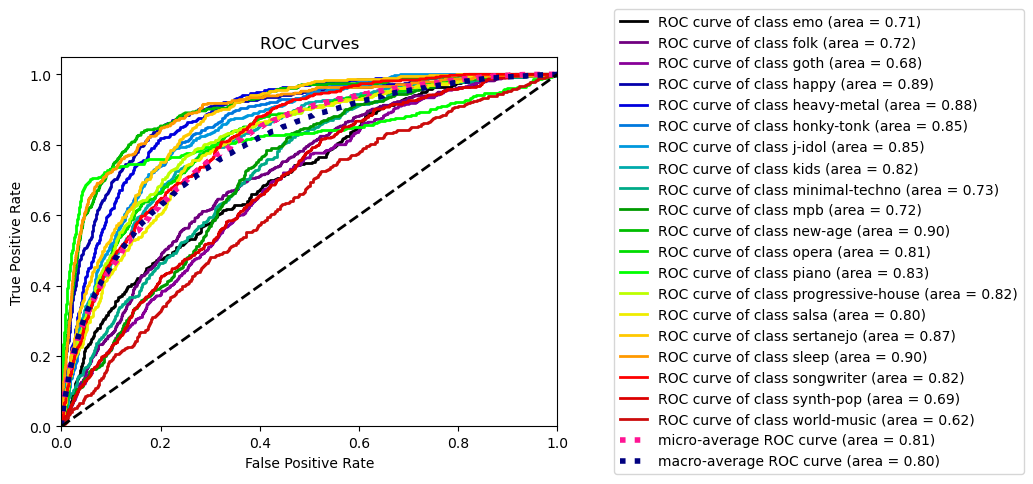

TOP 5 F1-SCORE:
piano: 0.5326757090012331
new-age: 0.4239766081871345
happy: 0.41604010025062654
heavy-metal: 0.35390334572490706
sleep: 0.2948960302457467


FLOP 5 F1-SCORE:
folk: 0.0
world-music: 0.0
synth-pop: 0.005277044854881266
emo: 0.046189376443418015
goth: 0.05


In [17]:
# naive bayes selected model
model = GaussianNB()
y_pred = decode_y(cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10), enc_dict)
y_pred_proba = cross_val_predict(model, train_dtw_pca_paa, y_train_paa, cv=10, method='predict_proba')

print(classification_report(decode_y(y_train_paa, enc_dict), y_pred))
plot_roc(decode_y(y_train_paa, enc_dict), y_pred_proba)
plt.legend(loc='center left',prop={'size': 10}, bbox_to_anchor=(1.1, 0.5))
plt.show()

top_flop_f1(decode_y(y_train_paa, enc_dict), y_pred)

test:

In [26]:
# knn
clf = KNeighborsClassifier(n_neighbors=150,metric='cosine', n_jobs=-1, weights='distance')
clf.fit(train_dtw_pca_paa, y_train_paa)
y_pred = clf.predict(test_dtw_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.25      0.10      0.15       125
             folk       0.07      0.02      0.04       125
             goth       0.00      0.00      0.00       125
            happy       0.39      0.50      0.44       125
      heavy-metal       0.29      0.43      0.35       125
       honky-tonk       0.22      0.46      0.30       125
           j-idol       0.26      0.30      0.28       125
             kids       0.27      0.35      0.31       125
   minimal-techno       0.41      0.13      0.20       125
              mpb       0.14      0.04      0.06       125
          new-age       0.41      0.50      0.45       125
            opera       0.17      0.13      0.15       125
            piano       0.56      0.46      0.51       125
progressive-house       0.32      0.27      0.29       125
            salsa       0.19      0.40      0.25       125
        sertanejo       0.23      0.59      0.33       

In [27]:
# decision tree
clf = DecisionTreeClassifier(criterion='entropy', max_depth=8, min_samples_leaf=6,
                       min_samples_split=100, random_state=8)
clf.fit(train_dtw_pca_paa, y_train_paa)
y_pred = clf.predict(test_dtw_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.26      0.07      0.11       125
             folk       0.10      0.04      0.06       125
             goth       0.09      0.01      0.01       125
            happy       0.22      0.38      0.28       125
      heavy-metal       0.31      0.32      0.32       125
       honky-tonk       0.23      0.45      0.30       125
           j-idol       0.23      0.26      0.24       125
             kids       0.28      0.40      0.33       125
   minimal-techno       0.09      0.09      0.09       125
              mpb       0.00      0.00      0.00       125
          new-age       0.39      0.47      0.42       125
            opera       0.18      0.10      0.13       125
            piano       0.58      0.46      0.51       125
progressive-house       0.21      0.25      0.23       125
            salsa       0.17      0.41      0.24       125
        sertanejo       0.20      0.51      0.29       

c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [28]:
# naive bayes
clf = GaussianNB()
clf.fit(train_dtw_pca_paa, y_train_paa)
y_pred = clf.predict(test_dtw_pca_paa)
print(classification_report(decode_y(y_test_paa, enc_dict), decode_y(y_pred, enc_dict)))

                   precision    recall  f1-score   support

              emo       0.25      0.03      0.06       125
             folk       0.00      0.00      0.00       125
             goth       0.06      0.02      0.03       125
            happy       0.37      0.46      0.41       125
      heavy-metal       0.26      0.62      0.36       125
       honky-tonk       0.23      0.47      0.31       125
           j-idol       0.25      0.30      0.27       125
             kids       0.33      0.26      0.29       125
   minimal-techno       0.34      0.08      0.13       125
              mpb       0.07      0.04      0.05       125
          new-age       0.45      0.38      0.41       125
            opera       0.21      0.26      0.23       125
            piano       0.47      0.57      0.51       125
progressive-house       0.28      0.22      0.24       125
            salsa       0.16      0.25      0.19       125
        sertanejo       0.20      0.78      0.32       

c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\giuli\anaconda3\envs\DEEPL\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
